In [1]:
# Import the libraries we have used before to re-use in this tutorial.

import numpy # https://numpy.org/
import pandas # https://pandas.pydata.org/

# visualization
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt  # https://matplotlib.org/
import seaborn as sns # https://seaborn.pydata.org/

# assessment
from sklearn import model_selection 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

# models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm


# data preprocessing / feature selection
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# combining
from sklearn.pipeline import make_pipeline

#########

In [2]:
print('Loading data from file ...')  # Now let's load the data from the floats.csv file (same as before)
dataset = pandas.read_csv('floats.csv') 
print('done \n')

print('Removing rows with missing data ...')  
dataset = dataset.dropna()  
print('done \n')

# Let's set up the same prediction problem as before: 
print('Reading list of problem variables X and Y...')
X_name = [ 'Depth', 'Temperature', 'Salinity' ] 
X = dataset[X_name]   
y_name = 'callSign'   
y = dataset[y_name]   

# And set up our standard assessment framework:

# We partition our data into two parts: train (for formative development) and test (for summative evaluation) ...
# We also set the random number seed before each run to ensure that the evaluation of each algorithm is performed using exactly the same data splits. 
# It ensures the results are directly comparable.
test_pct = 0.20   # reserve a random 20% of the data points for testing performance
seed = 7          # setting the seed means that _the_same_ 20% will be split for testing every time we run this notebook - this allows for repeatability/reproducibility
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_pct, random_state=seed)

# Chose the scoring method
scoring_method = 'f1_micro'
print('done \n')


Loading data from file ...
done 

Removing rows with missing data ...
done 

Reading list of problem variables X and Y...
done 



             Depth  Temperature     Salinity
count  8016.000000  8016.000000  8016.000000
mean    301.914047    16.236374    35.815595
std     267.919409     7.883340     0.693264
min       2.000000     4.670000    28.750000
25%      75.000000     8.680000    35.020000
50%     220.500000    16.020000    36.040000
75%     494.000000    23.020000    36.460000
max     996.000000    31.710000    36.900000


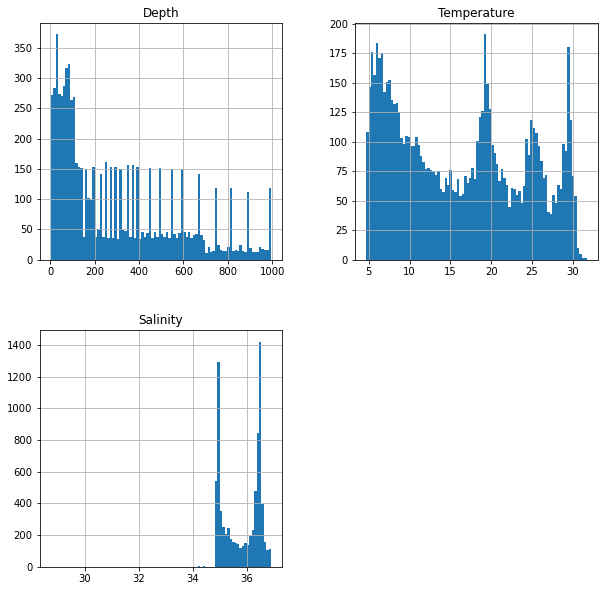

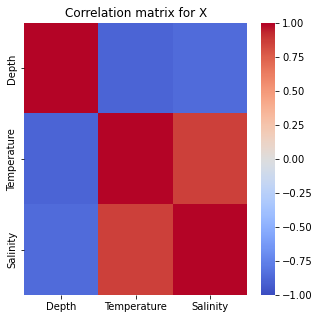

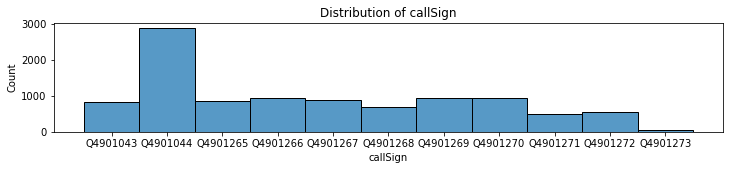

In [3]:
# We already know what the floats data looks like, but let's double check
# EDA examples
print(X_train.describe(include='all'))

X_train.hist(figsize=(10, 10), bins=90)  # bins ~= sqrt(N)
plt.show()

plt.figure(figsize=(5, 5))
corr = X.corr()    # compute the correlation between the variables
sns.heatmap( corr, cmap='coolwarm', vmax=1.0, vmin=-1.0 );   # plot it as a heat map
plt.title('Correlation matrix for X')
plt.show()

plt.figure(figsize=(12, 2))
sns.histplot(data=y)
plt.title('Distribution of callSign')
plt.show()

In [5]:
# Choose the Algorithms

seed = 42 # setting the seed allows for repeatability

print('Reading list of algorithms to train ...')
models = []
models.append(( 'raw_SVM', svm.SVC(random_state=seed) ))
models.append(( 'scaled_SVM', make_pipeline( MinMaxScaler(), svm.SVC(random_state=seed) )  ))
models.append(( 'raw_kNN', KNeighborsClassifier() ))
models.append(( 'scaled_kNN', make_pipeline( MinMaxScaler(), KNeighborsClassifier() )  ))
models.append(( 'raw_DT', DecisionTreeClassifier(random_state=seed) ))
models.append(( 'scaled_DT', make_pipeline( MinMaxScaler(), DecisionTreeClassifier(random_state=seed) )  ))
print('done \n')

Reading list of algorithms to train ...
done 



In [6]:
# Now it is time to train some models on the data and estimate their accuracy on unseen data.

k4folds = 5
results = []
names = []
for name, model in models:   # Select each model in turn
    print(" ++ NOW WORKING ON ALGORITHM %s ++" % name)
# create the five folds of the TRAINING data
    print("Splitting data into %s folds" % k4folds)    
    kfold = model_selection.KFold(n_splits=k4folds, random_state=seed, shuffle=True)   
# fit the model using four parts at a time and then validate it on the oher part that was set aside; and repeat five times.
    print("Training model and validating it on each fold") 
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring_method) 
    results.append(cv_results)
    names.append(name)
# some fancy footwork for printing the results
    msg = "algorithm %s %s results: mean = %f (std = %f)" % (name, scoring_method, cv_results.mean(), cv_results.std())
    print(msg)
    print('\n')
    
print('done \n')   # Note that we have not used any of the test data yet!

 ++ NOW WORKING ON ALGORITHM raw_SVM ++
Splitting data into 5 folds
Training model and validating it on each fold
algorithm raw_SVM f1_micro results: mean = 0.288795 (std = 0.011246)


 ++ NOW WORKING ON ALGORITHM scaled_SVM ++
Splitting data into 5 folds
Training model and validating it on each fold
algorithm scaled_SVM f1_micro results: mean = 0.388597 (std = 0.007660)


 ++ NOW WORKING ON ALGORITHM raw_kNN ++
Splitting data into 5 folds
Training model and validating it on each fold
algorithm raw_kNN f1_micro results: mean = 0.439744 (std = 0.009812)


 ++ NOW WORKING ON ALGORITHM scaled_kNN ++
Splitting data into 5 folds
Training model and validating it on each fold
algorithm scaled_kNN f1_micro results: mean = 0.464448 (std = 0.008370)


 ++ NOW WORKING ON ALGORITHM raw_DT ++
Splitting data into 5 folds
Training model and validating it on each fold
algorithm raw_DT f1_micro results: mean = 0.462326 (std = 0.014867)


 ++ NOW WORKING ON ALGORITHM scaled_DT ++
Splitting data into 5 f

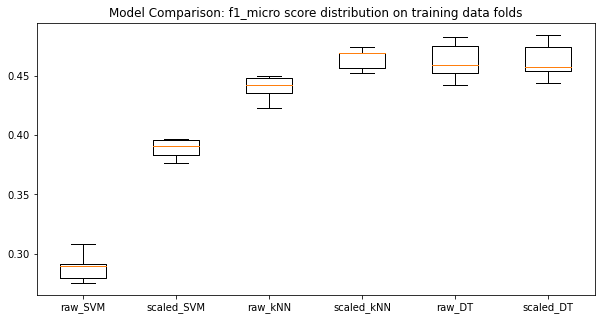

In [7]:
# Graphical comparison 
fig = plt.figure(figsize=(10, 5)).add_subplot(111) # Create a figure with a single plot inside (1 row, 1 column, 1st plot)
plt.boxplot(results)                               # Draw boxplots for the results of each model
fig.set_xticks(range(1, len(names) + 1))           # Create tickmarks for each model (1-based index for boxplot)
fig.set_xticklabels(names)                         # Place the name of each model at the corresponding tickmark
plt.title('Model Comparison: %s score distribution on training data folds' % scoring_method)
plt.show()

 ++++ Detailed classification report for the selected model ++++ 
Model is Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())]) 
This model was trained and tuned on the development set using CV.
The following results are computed on the separate test set:

 clasification report:
               precision    recall  f1-score   support

    Q4901043       0.71      0.94      0.81       149
    Q4901044       0.74      0.88      0.80       575
    Q4901265       0.31      0.45      0.37       179
    Q4901266       0.20      0.19      0.19       198
    Q4901267       0.31      0.29      0.30       181
    Q4901268       0.25      0.17      0.20       154
    Q4901269       0.21      0.16      0.18       187
    Q4901270       0.25      0.21      0.22       183
    Q4901271       0.14      0.11      0.13        89
    Q4901272       0.28      0.11      0.16        99
    Q4901273       0.00      0.00      0.00        11

    a

/project/cacds/apps/anaconda3/5.0.1/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/project/cacds/apps/anaconda3/5.0.1/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/project/cacds/apps/anaconda3/5.0.1/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

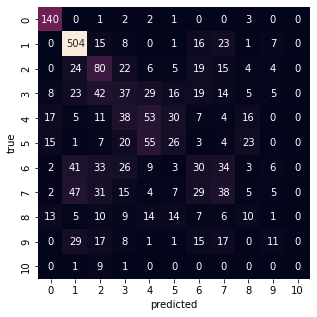

In [8]:
# First we retrain the most capable model using ALL of the training data
selected_model = make_pipeline( MinMaxScaler(),KNeighborsClassifier() ) 
selected_model.fit(X_train, y_train)

# Next we use this retrained model on the test set and summarize the results 
# as a final confusion matrix and a classification report.
y_predicted = selected_model.predict(X_test)

print(" ++++ Detailed classification report for the selected model ++++ " )
print("Model is %s " % selected_model)
print("This model was trained and tuned on the development set using CV.")
print("The following results are computed on the separate test set:")
print('\n clasification report:\n', classification_report(y_test, y_predicted))  # several metrics reported in table form
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix(y_test, y_predicted), square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()
